# Data Analysis

We group ip addresses by url type

In [10]:
import pandas as pd
cols = ['ip', 'bitvector', 'throughput', 'url', 'total_bytes', 'url_type']
df = pd.read_csv("./data/raw_data.csv", names=cols, header=0, delimiter=',')
df['url_type'].value_counts()


pdf      9120
image    7707
other    1398
video     429
Name: url_type, dtype: int64

Video files are large and therefore have a very high throughput. Throuhput of video files is not in-line with other  types.


 ### Ip Address v/s Throughput to see if there are rows that are potential outliers

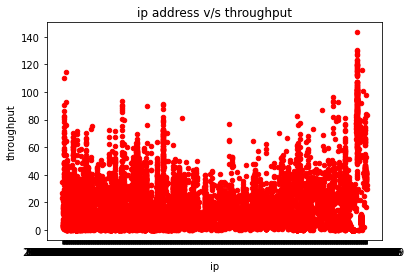

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

cols = ['ip', 'bitvector', 'throughput', 'url', 'total_bytes', 'url_type']
df = pd.read_csv("./data/raw_data.csv", names=cols, header=0, delimiter=',')
# a scatter plot comparing ip_address and throughput
df.plot(title='ip address v/s throughput', kind='scatter',x='ip',y='throughput', color='red')
plt.show()

### Ip Address v/s Throughput after cleaning the rows


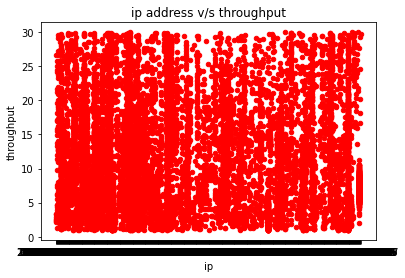

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

cols = ['ip', 'bitvector', 'throughput', 'url', 'total_bytes', 'url_type']
df = pd.read_csv("./data/data.csv", names=cols, header=0, delimiter=',')
# a scatter plot comparing ip_address and throughput
df.plot(title='ip address v/s throughput', kind='scatter',x='ip',y='throughput', color='red')
plt.show()

Now the data looks much more clustered and does not seem to have outliers.

#### Density of throughput values

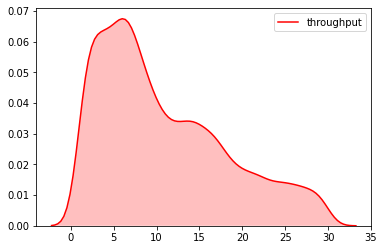

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['ip', 'bitvector', 'throughput', 'url', 'total_bytes', 'url_type']
df = pd.read_csv("./data/data.csv", names=cols, header=0, delimiter=',')
density = sns.kdeplot(df['throughput'], shade=True, color="r", title)

The throughputs distribution is non-trivial, with multiple bumps and a long tail. Creating neural architecture to fit the data looks challenging

#### group by url type on cleaned data

In [19]:
import pandas as pd
cols = ['ip', 'bitvector', 'throughput', 'url', 'total_bytes', 'url_type']
df = pd.read_csv("./data/data.csv", names=cols, header=0, delimiter=',')
url_types = df['url_type'].value_counts()
print(url_types)

pdf      7860
image    5996
other    1065
video      35
Name: url_type, dtype: int64


I lost 91% of video files after cleaning. Video files are large files that had high throughput

# TCP slow start

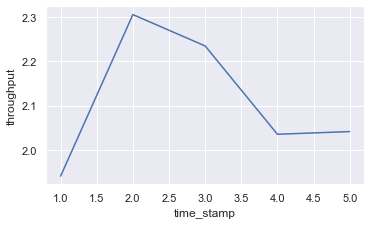

In [32]:
import matplotlib.pyplot as plt
cols = ['time_stamp', 'ip_adress', 'throughput', ]
t = pd.read_csv("./data/tcp.csv", names=cols, header=0, delimiter=',')
sns.set(rc={'figure.figsize':(5.7,3.27)})
ax = sns.lineplot(x="time_stamp", y="throughput", data=t)

#  Model selection

I have tried the following model:

CNN with bidirectional LSTM followed by 4 Dense layers and an output layer

####  CNN with bidirectional LSTM followed by 4 Dense layers and an output layer

In [9]:
import pandas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


def cnn_lstm_model():
    model = Sequential(name='cnn_lstm_model')
    model.add(Conv1D(128, 16, activation='relu', input_shape=(32, 1)))
    model.add(MaxPooling1D(pool_size=8))
    model.add(Bidirectional(LSTM(128, kernel_initializer='glorot_uniform', activation='relu')))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    # Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

cnn_lstm_model_compiled = cnn_lstm_model()
cnn_lstm_model_compiled.summary()

Model: "cnn_lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 17, 128)           2176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 128)            

The intuition behind using cnn lstm layer was that, Convolutional layer would act as feature extractor and lstm layer would act as a sequence predictor.
4 digits of ip adress are converted to 32 bit vector representation with 8 bits for each of the 4 numbers respectively. The 32 bit vector is fed into the above network as input data. 

__Layer 1__: CNN layer is the 1 dimentional input layer that takes the 32 bits as input. This layer has filter of size 16 and has 160 paramters. This totals to 32-16+1 * 160 = 2720 paramters.
Inputs-filters+1 * number_of_parameters.
I experimented with different filter settings ranging from 4, 8 and 16. Having 16 as the filter size gave me good results.

__Layer 2__: This a 1D max pooling layer that reduces the size of the representation thereby reducing the parameters in the network. This will also reduce the computations in the network. Again I have experimented with different pooling sizes ranging from 2, 4 and 8. Having 8 as the pooling size gave me good results.
Max pooling considers block of 8 parameters and takes the max value of the 8 parameters.

__Layer 3__: This layer is Bidirectional-LSTM layer that would act as a sequence predictor. Ip address is a sequential information and this layer is to learn that hidden sequence information. I used the standard suggested 'glorot_uniform' initializer.

__Layers 4__ to Layers 7: These are stack of Dense layers each with 160 parameters, and kernel initializers set to 'normal'

__Layer 8__: This is a Dropout layer to help reduce the overfitting in the model. Without this layer, the model performed better on training set and bad on validation set. I will talk more about overfitting in following sections. I have experimented with different Dropout setting ranging from 0.2, 0.4 and 0.5. Having 0.5 gave me better results.

__Layer 9__: This is a standard output layer with 1 parameter to predict and output the throughput predicted by the netwwork.

__Activation Function__: 'Relu': I have used 'relu' as the activation function. I have experimented with _tanh_ and _relu_ activation functions and I found that 'relu' is better compared to tanh as it gave me good results. Also 'relu' accelerated SGD stochastic gradient descent to reach convergence faster. "ImageNet Classification with Deep Convolutional Neural Networks" [http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf]

__Loss__: I have used 'MSE' as the loss function as this is the function I want to reduce while training the network.

__Optimizer__: I have used 'adam' optimizer. I have tried with SGD stochastic Gradient descent with different learning rates. Having adam as the optimizer gave good results and also adam automatically adjusts the learning rate as the learning progresses.

__Parameter size__: I have experimented with various parameters numbers on different layers. However I have maintained same parameter numbers in the hidden layers while I had a different number on the input layer. I have started with large numbers like 1024 for all layers and reduced to 512, 256, 190 and 160. With large number was overfitting with low loss on training set high loss of validation set. As I gradually reduced  the numbers I started seeing training loss and validation loss getting closer to each other. I stopped just before the validation loss went lower than training loss. Following figure will depict the overfitting effect on one of the 10 fold cv's


#### Overfitting

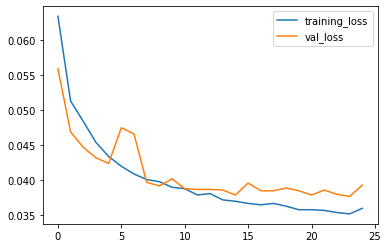

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
cols = ['training_loss', 'val_loss', ]
t = pd.read_csv("./outputs/overfitting_overfitted.csv", names=cols, delimiter=',')

plt.plot(t['training_loss'], label='training_loss')
plt.plot(t['val_loss'], label='val_loss')
plt.legend()

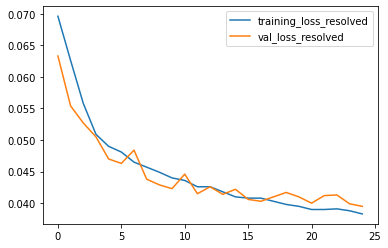

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
cols = ['training_loss', 'val_loss', ]
t = pd.read_csv("./outputs/overfitting_resolved.csv", names=cols, delimiter=',')

plt.plot(t['training_loss'], label='training_loss_resolved')
plt.plot(t['val_loss'], label='val_loss_resolved')
plt.legend()

# 10 fold Cross validation

10 fold cross validation was performed on devset and following settings were adjusted
1. Number of parameters in the layers were changed from 512, 256, 192, 160 and to 128
2. Number of epochs was changed from 50 to 10 and then set to 25.
3. Loss remained the same and was set to ‘MSE’
4. Learning rate: I started with SGD as the optimizer and set the values from 0.01 and 0.0001. However, using the ‘adam’ optimizer, I got good results and it also adjusts learning rate as training progresses
5. Activation function was set to ‘Relu’. I tried ‘tanh’ and ended up using ‘relu’ as it gave me good results.


Following are the values of 10 fold cv


1. 0.04040479030808288
2. 0.04197440368294558
3. 0.03924952800737763
4. 0.04260239671184757
5. 0.03996116059147406
6. 0.04154475790220107
7. 0.04080199080481794
8. 0.03735164575395976
9. 0.04078529242611844
10. 0.040870060522810656

Avergage mean squred error: 0.04055460267



#### Actual v/s predicted values of Cross validated fold number 1.

Following chart shows the predicted througput values as compared to the actual throughput values. The shaded or blured part on the chart shows the points where the prediction values are exactly equivalent to the predicted output

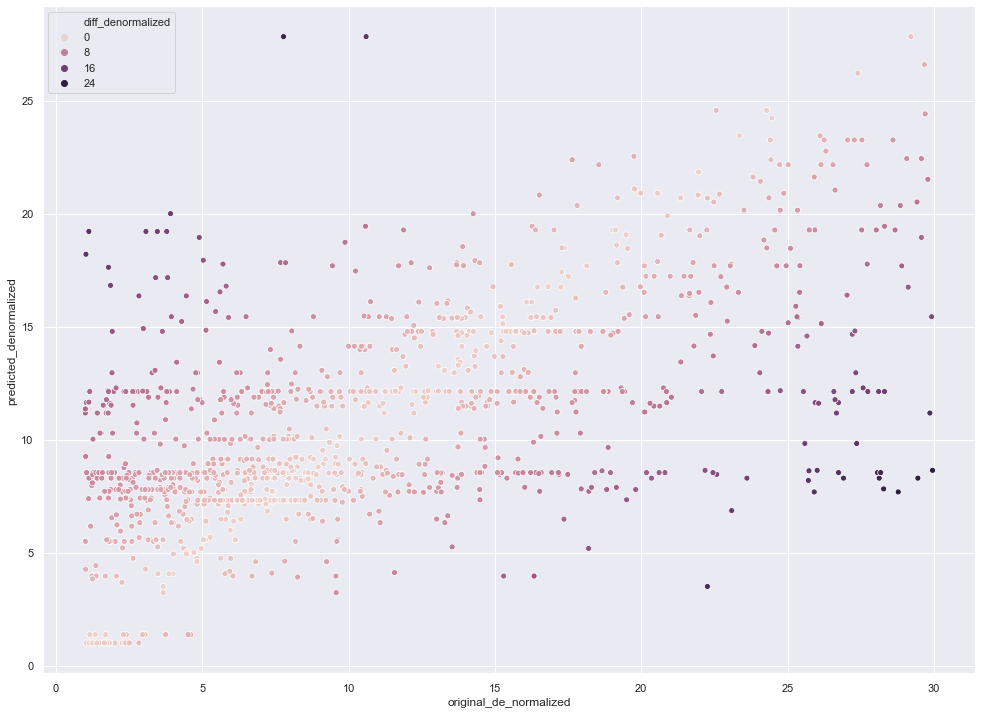

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
cols = ['ip', 'bit_vector', 'original_de_normalized', 'url', 'length', 'url_type', 'original_normalized', 'predicted_normalized','diff_normalized', 'predicted_denormalized', 'diff_denormalized']
df_new = pd.read_csv("./outputs/disagreements/output_disagreement_1.csv", names=cols, delimiter=',')
sns.set(rc={'figure.figsize':(16.7,12.27)})
sns.set_palette("dark")
plot = sns.scatterplot(x="original_de_normalized", y="predicted_denormalized", hue='diff_denormalized', color='red' ,data=df_new)

# Results on Test set

Using all of the devset_normalized.csv, model was created and saved to ../../models/model_final.h5 location. Upon loading the saved file and test on held out test set ‘testset_normalized.csv’ following results were seen.

__Mean squared Error on test set: 0.04061568903523597__


# Actual v/s predicted values for test set

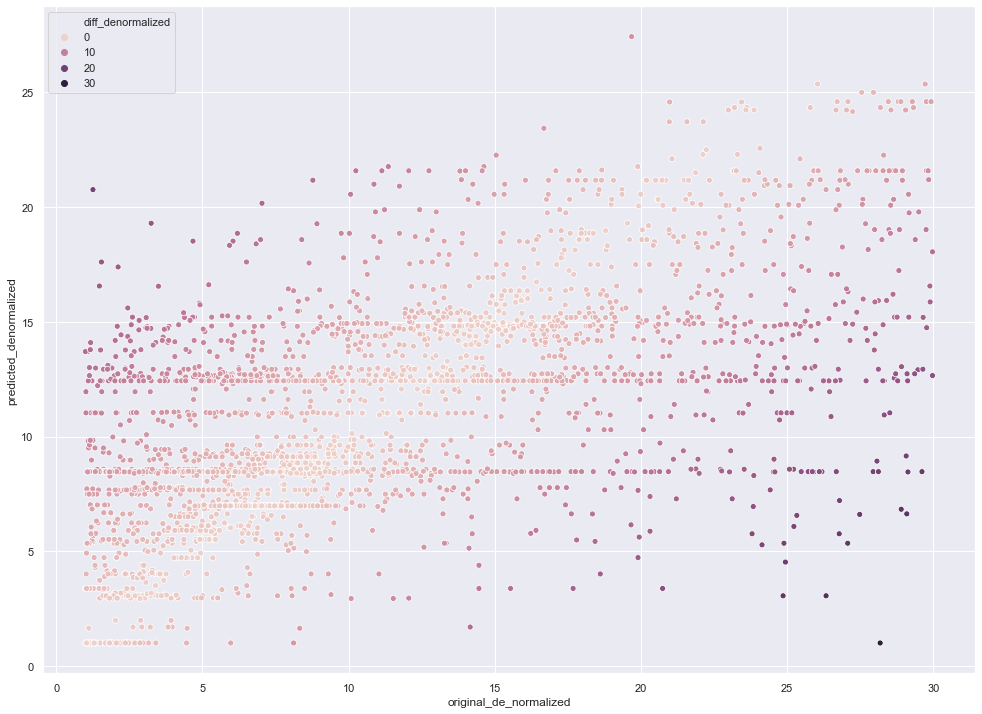

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
cols = ['ip', 'bit_vector', 'original_de_normalized', 'url', 'length', 'url_type', 'original_normalized', 'predicted_normalized','diff_normalized', 'predicted_denormalized', 'diff_denormalized']
df_new = pd.read_csv("./outputs/final_output.csv", names=cols, delimiter=',')
sns.set(rc={'figure.figsize':(16.7,12.27)})
sns.set_palette("dark")
plot = sns.scatterplot(x="original_de_normalized", y="predicted_denormalized", hue='diff_denormalized', color='red' ,data=df_new)